In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls -al /content/drive/Shareddrives/DA231-2023/assignments/spark-3.0.3-bin-hadoop2.7.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2023/assignments/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"



import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()


from pyspark import SparkContext, SparkConf
sc = SparkContext.getOrCreate()





Mounted at /content/drive
-r-------- 1 root root 220400553 Sep  4 09:38 /content/drive/Shareddrives/DA231-2023/assignments/spark-3.0.3-bin-hadoop2.7.tgz


In [2]:
from pyspark.sql.types import *
file = '/content/drive/MyDrive/Data Engineering - Crime Analysis/DataSource/Crime_Data_from_2020_to_Present.csv'
schema = StructType([
    StructField('DR_NO', StringType(), metadata={"description": "Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits"}),
    StructField('Date Rptd', StringType(), metadata={"description": "Format:- MM/DD/YYYY"}),
    StructField('DATE OCC', StringType(), metadata={"description": "Format:- MM/DD/YYYY"}),
    StructField('TIME OCC', StringType(), metadata={"description": "In 24 hour military time."}),
    StructField('AREA', StringType(), metadata={"description": "The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21."}),
    StructField('AREA NAME', StringType(), metadata={"description": "The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles."}),
    StructField('Rpt Dist No', StringType(), metadata={"description": "A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the \"RD\" that it occurred in for statistical comparisons. Find LAPD Reporting Districts on the LA City GeoHub at http://geohub.lacity.org/datasets/c4f83909b81d4786aa8ba8a74a4b4db1_4 "}),
    StructField('Part 1-2', IntegerType(), metadata={"description": ""}),
    StructField('Crm Cd', StringType(), metadata={"description": "Indicates the crime committed. (Same as Crime Code 1)",}),
    StructField('Crm Cd Desc', StringType(), metadata={"description": "Defines the Crime Code provided."}),
    StructField('Mocodes', StringType(), metadata={"description": "Modus Operandi: Activities associated with the suspect in commission of the crime.See attached PDF for list of MO Codes in numerical order. https://data.lacity.org/api/views/y8tr-7khq/files/3a967fbd-f210-4857-bc52-60230efe256c?download=true&filename=MO%20CODES%20(numerical%20order).pdf"}),
    StructField('Vict Age', IntegerType(), metadata={"description": "Age of the victim"}),
    StructField('Vict Sex', StringType(), metadata={"description": "F - Female M - Male X - Unknown"}),
    StructField('Vict Descent', StringType(), metadata={"description": "Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian"}),
    StructField('Premis Cd', IntegerType(), metadata={"description": "The type of structure, vehicle, or location where the crime took place."}),
    StructField('Premis Desc', StringType(), metadata={"description": "Defines the Premise Code provided."}),
    StructField('Weapon Used Cd', StringType(), metadata={"description": "The type of weapon used in the crime. "}),
    StructField('Weapon Desc', StringType(), metadata={"description": "Defines the Weapon Used Code provided."}),
    StructField('Status', StringType(), metadata={"description": "Status of the case. (IC is the default)"}),
    StructField('Status Desc', StringType(), metadata={"description": "Defines the Status Code provided."}),
    StructField('Crm Cd 1', StringType(), metadata={"description": "Indicates the crime committed. Crime Code 1 is the primary and most serious one. Crime Code 2, 3, and 4 are respectively less serious offenses. Lower crime class numbers are more serious."}),
    StructField('Crm Cd 2', StringType(), metadata={"description": "May contain a code for an additional crime, less serious than Crime Code 1. "}),
    StructField('Crm Cd 3', StringType(), metadata={"description": "May contain a code for an additional crime, less serious than Crime Code 1."}),
    StructField('Crm Cd 4', StringType(), metadata={"description": "May contain a code for an additional crime, less serious than Crime Code 1."}),
    StructField('LOCATION', StringType(), metadata={"description": "Street address of crime incident rounded to the nearest hundred block to maintain anonymity."}),
    StructField('Cross Street', DecimalType(), metadata={"description": "Cross Street of rounded Address"}),
    StructField('LAT', DecimalType(), metadata={"description": "Latitude"}),
    StructField('LON', DecimalType(), metadata={"description": "Longitude"})
])

crime_df = spark.read.csv(file, header=True, schema=schema)

In [3]:
# data cleaning and data munging to use them in processing.
# Date formats and military format conversion
from pyspark.sql.functions import col, from_unixtime, unix_timestamp, date_format, when, length, concat, lit

parsed_crime_df = crime_df.withColumn('Date Rptd', date_format(from_unixtime(unix_timestamp(col('Date Rptd'), 'MM/dd/yyy hh:mm:ss a')), 'MM/dd/yyyy')).withColumn(
    'DATE OCC', date_format(from_unixtime(unix_timestamp(col('DATE OCC'), 'MM/dd/yyy hh:mm:ss a')), 'MM/dd/yyyy'))
#convert Military hour format to readable time format hh:mm
#Precede with 0 if the number of digits is 3 else null if less than 3 digits, then convert to time format
time_parsed_crime_df = parsed_crime_df.withColumn('TIME OCC', when(length(col('TIME OCC')) == 4, col('TIME OCC')).when(length(col('TIME OCC')) == 3, concat(
    lit('0'), col('TIME OCC'))).when(length(col('TIME OCC')) == 2, concat(
    lit('00'), col('TIME OCC'))).when(length(col('TIME OCC')) == 1, concat(
    lit('000'), col('TIME OCC'))).otherwise(None)).withColumn('TIME OCC', (date_format(from_unixtime(unix_timestamp(col('TIME OCC'), "HHmm")), "HH:mm")))


# filter records whose age is <= 0, sex = '-', ''
filtered_DF = time_parsed_crime_df.filter((col('Vict Age') > 0) & (col('Vict Sex').isin(['F', 'M','H','X'])) )

#convert 'Rpt Dist No' as numeric for ml
filtered_DF = filtered_DF.withColumn('Rpt Dist No', col('Rpt Dist No').cast('int'))
filtered_DF.select(col('Vict Descent')).distinct().show()
filtered_DF.show(2)
filtered_DF.printSchema()

+------------+
|Vict Descent|
+------------+
|           K|
|           F|
|        null|
|           B|
|           L|
|           V|
|           U|
|           O|
|           D|
|           C|
|           J|
|           -|
|           Z|
|           A|
|           X|
|           W|
|           S|
|           G|
|           I|
|           P|
+------------+
only showing top 20 rows

+---------+----------+----------+--------+----+---------+-----------+--------+------+--------------------+--------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+--------+--------+--------------------+------------+---+----+
|    DR_NO| Date Rptd|  DATE OCC|TIME OCC|AREA|AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|       Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|C

In [5]:
empty_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)

# Display descriptions for all columns in the DataFrame
for field in empty_df.schema:
    print(f"Column: {field.name}")
    if "description" in field.metadata:
        print(f"Description: {field.metadata['description']}")
    else:
        print("No description available")
    print("------------------------")


#Distribution and characteristics of the data within each column, aiding in initial data exploration and understanding of the dataset's properties.

parsed_crime_df.describe().show()


crime_desc = filtered_DF.groupBy('Vict Sex').agg({'Crm Cd Desc':'collect_list'})
crime_desc.show()

Column: DR_NO
Description: Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits
------------------------
Column: Date Rptd
Description: Format:- MM/DD/YYYY
------------------------
Column: DATE OCC
Description: Format:- MM/DD/YYYY
------------------------
Column: TIME OCC
Description: In 24 hour military time.
------------------------
Column: AREA
Description: The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21.
------------------------
Column: AREA NAME
Description: The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles.
------------------------
Column: Rpt Dist No
Description: A four-digit cod

In [6]:
from pyspark.sql import functions as F
crime_desc = filtered_DF.groupBy('Vict Sex').agg(F.collect_list('Crm Cd Desc').alias('CrimeDescriptions'))
crime_desc.show()

+--------+--------------------+
|Vict Sex|   CrimeDescriptions|
+--------+--------------------+
|       F|[BATTERY - SIMPLE...|
|       M|[BATTERY - SIMPLE...|
|       X|[VANDALISM - FELO...|
|       H|[VANDALISM - FELO...|
+--------+--------------------+



In [7]:
from pyspark.sql.functions import collect_set, count, avg, max, min
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
#use case-I
#Vict age, sex and Descent against crm cd desc. filter age = 0, < 0 since this is invalid age.
effected_victims_DF = filtered_DF.groupBy(col('Crm Cd Desc')).agg(count(col('Vict Age')).alias('number of victims'),  \
                                                     max(col('Vict Age')).alias('highest age of victim per crime desc'), \
                                                     collect_set(col('Vict Sex')).alias('sex'), \
                                                     collect_set(col('Vict Descent')).alias('Descent')).orderBy(col('number of victims').desc())
#top 10
effected_victims_DF.show(10)

+--------------------+-----------------+------------------------------------+------------+--------------------+
|         Crm Cd Desc|number of victims|highest age of victim per crime desc|         sex|             Descent|
+--------------------+-----------------+------------------------------------+------------+--------------------+
|BATTERY - SIMPLE ...|            63039|                                  99|[F, M, H, X]|[K, P, C, Z, S, X...|
|   THEFT OF IDENTITY|            50247|                                  99|[F, M, H, X]|[K, C, P, Z, S, X...|
|BURGLARY FROM VEH...|            47849|                                  99|[F, M, H, X]|[K, C, P, Z, S, X...|
|ASSAULT WITH DEAD...|            44405|                                  99|[F, M, H, X]|[K, Z, S, X, U, F...|
|INTIMATE PARTNER ...|            40069|                                  99|[F, M, H, X]|[K, C, P, Z, X, U...|
|VANDALISM - FELON...|            36944|                                  99|[F, M, H, X]|[K, C, P, Z, S

Text(0.5, 1.0, 'Top 10 Effected victims in LA')

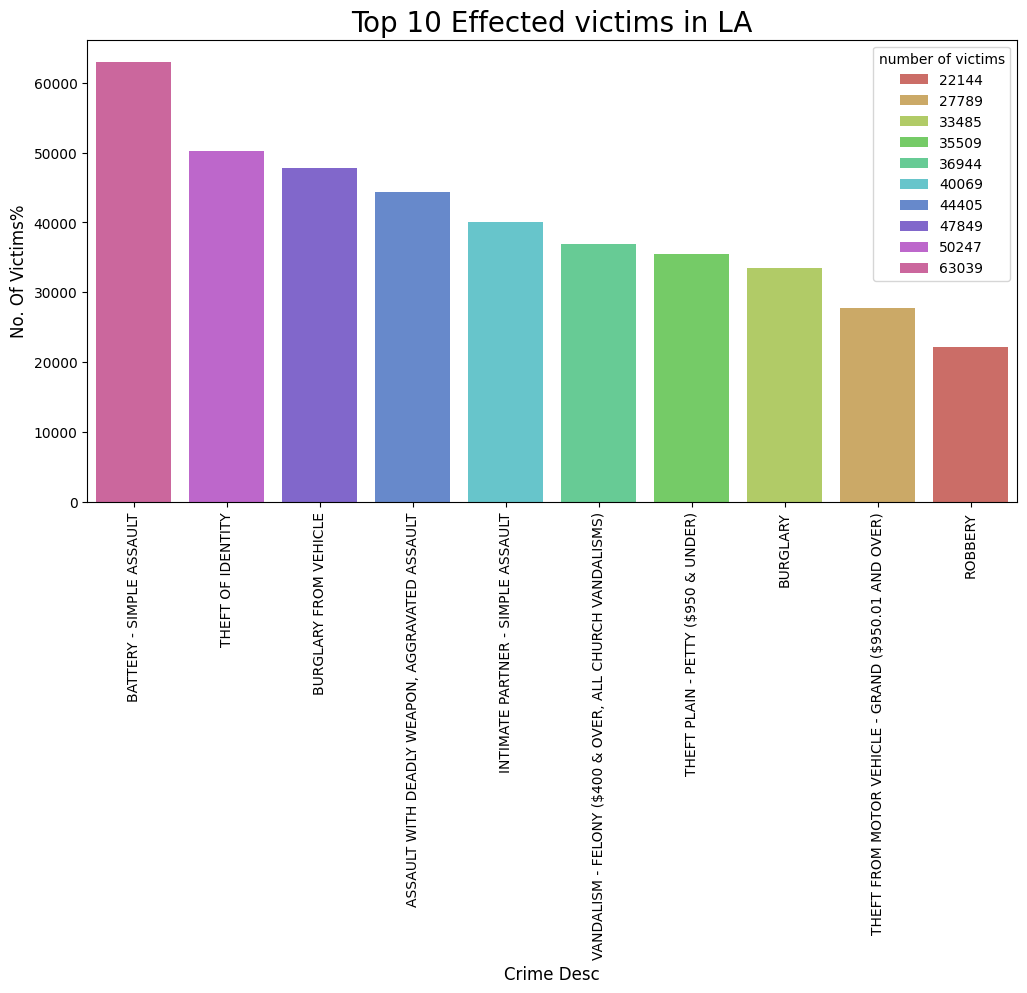

In [9]:

#using pandas
#victim_df = pd.DataFrame(effected_victims_DF).head(10)
victim_df = effected_victims_DF.toPandas().head(10)

plt.figure(figsize=(12, 6))
g=sns.barplot(  x = "Crm Cd Desc" , y = "number of victims" ,hue='number of victims', data = victim_df ,palette='hls', width=0.8,dodge=False )
# Set label for x-axis
g.set_xlabel( "Crime Desc" , size = 12 )
plt.xticks(rotation=90)

# Set label for y-axis
g.set_ylabel( "No. Of Victims%" , size = 12 )
# Set title for plot
g.set_title( "Top 10 Effected victims in LA" , size = 20 )
# Display figure
#---------------------------------------------------
#plt.show()

In [10]:
#Rank the AREA with type of highest occured crimes.

from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank

highest_crime_Area_df = filtered_DF.groupBy(['Crm Cd Desc', 'AREA NAME']).agg(count('AREA NAME').alias('crime count'))
highest_crime_DF = highest_crime_Area_df.withColumn('highest Crime', dense_rank().over(Window.partitionBy(col('crime count')).orderBy(col('Crm Cd Desc')))).where(col('highest Crime') == 1).select(['AREA NAME', 'Crm Cd Desc']).distinct()#.orderBy(col('crime count').desc())
highest_crime_DF.show()
#plot_graph(highest_crime_DF.select(['AREA NAME', 'highest Crime' ]), 22)

+-----------+--------------------+
|  AREA NAME|         Crm Cd Desc|
+-----------+--------------------+
|     Harbor|               ARSON|
|N Hollywood|CHILD ABUSE (PHYS...|
|   Wilshire|BURGLARY FROM VEH...|
|  Hollywood|BATTERY POLICE (S...|
|  Southwest|BURGLARY FROM VEH...|
|    Pacific|            BURGLARY|
|  Hollywood|THEFT FROM MOTOR ...|
| Devonshire|INTIMATE PARTNER ...|
|77th Street|BATTERY POLICE (S...|
|West Valley|     BRANDISH WEAPON|
| Hollenbeck|LETTERS, LEWD  - ...|
| Hollenbeck|       OTHER ASSAULT|
| Devonshire|LETTERS, LEWD  - ...|
|   Wilshire|            BURGLARY|
|  Hollywood|       OTHER ASSAULT|
|  Northeast|               ARSON|
|N Hollywood|   ATTEMPTED ROBBERY|
|    Olympic|INTIMATE PARTNER ...|
|    Olympic|BATTERY - SIMPLE ...|
|    West LA|THEFT FROM MOTOR ...|
+-----------+--------------------+
only showing top 20 rows



In [13]:
def plot_graph(input_df, head_cnt):
    # using pandas
    victim_df = input_df.toPandas().head(head_cnt)
    col_lst = victim_df.columns
    print(col_lst)
    plt.figure(figsize=(12, 6))
    g = sns.barplot(x=col_lst[0], y=col_lst[1], hue=col_lst[1], data=victim_df, palette='hls',
                    width=0.8, dodge=False)

    # Set label for x-axis
    g.set_xlabel("Crime Desc", size=12)
    plt.xticks(rotation=90)

    # Set label for y-axis
    g.set_ylabel("No. Of Victims%", size=12)

    # Set title for plot
    g.set_title("Top 10 Effected victims in LA", size=20)

    return plt.show()

+--------------------+-----------------+------------------------------------+------------+--------------------+
|         Crm Cd Desc|number of victims|highest age of victim per crime desc|         sex|             Descent|
+--------------------+-----------------+------------------------------------+------------+--------------------+
|BATTERY - SIMPLE ...|            63039|                                  99|[F, M, H, X]|[K, P, C, Z, S, X...|
|   THEFT OF IDENTITY|            50247|                                  99|[F, M, H, X]|[K, C, P, Z, S, X...|
|BURGLARY FROM VEH...|            47849|                                  99|[F, M, H, X]|[K, C, P, Z, S, X...|
|ASSAULT WITH DEAD...|            44405|                                  99|[F, M, H, X]|[K, Z, S, X, U, F...|
|INTIMATE PARTNER ...|            40069|                                  99|[F, M, H, X]|[K, C, P, Z, X, U...|
|VANDALISM - FELON...|            36944|                                  99|[F, M, H, X]|[K, C, P, Z, S

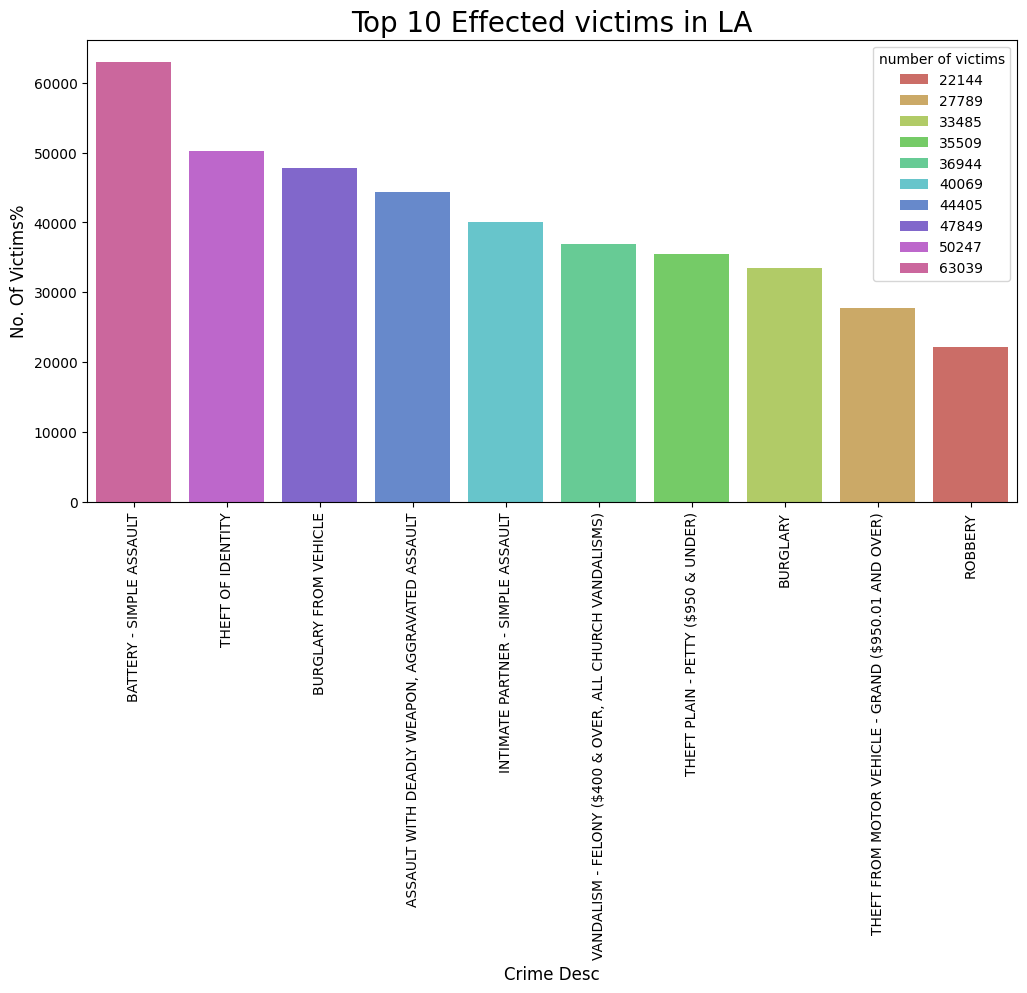

In [14]:
from pyspark.sql.functions import collect_set, count, avg, max, min
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#use case-I Vict age, sex and Descent against crm cd desc.
effected_victims_DF = filtered_DF.groupBy(col('Crm Cd Desc')).agg(count(col('Vict Age')).alias('number of victims'),  \
                                                     max(col('Vict Age')).alias('highest age of victim per crime desc'), \
                                                     collect_set(col('Vict Sex')).alias('sex'), \
                                                     collect_set(col('Vict Descent')).alias('Descent')).orderBy(col('number of victims').desc())

#top 10
effected_victims_DF.show(10)

plot_graph(effected_victims_DF.select(['Crm Cd Desc', 'number of victims' ]), 10)

Index(['Vict Sex', 'no of crimes'], dtype='object')


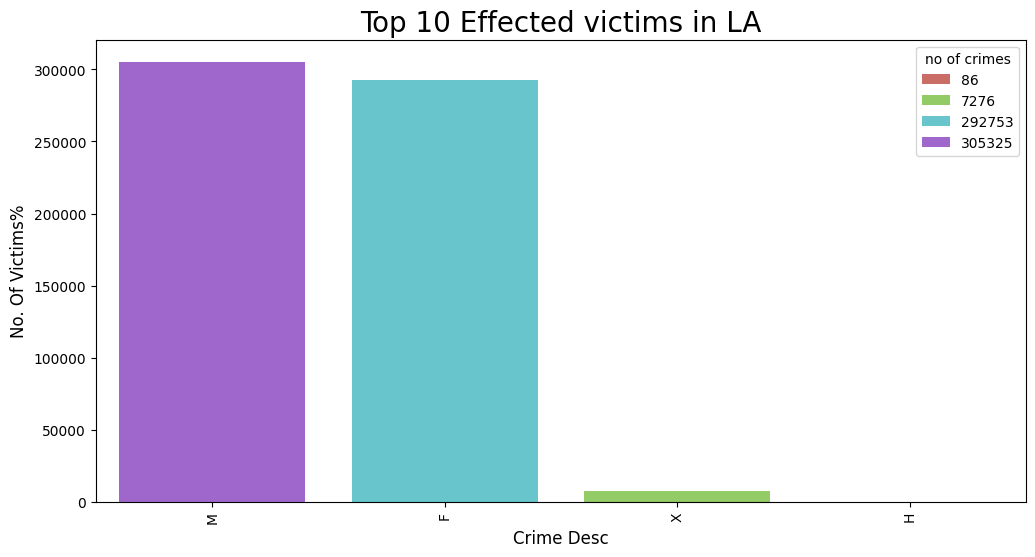

In [15]:

#No of crimes against F, M, T, -, #filter blank values as this is invalid
#X - Unknown
#H - NA
# -and blanks  - Removed during cleaning
gender_based_crimes = filtered_DF.groupBy(col('Vict Sex')).agg(count(col('Vict Sex')).alias('no of crimes')).orderBy(col('no of crimes').desc())

plot_graph(gender_based_crimes, 6)

Index(['AREA NAME', 'Age'], dtype='object')


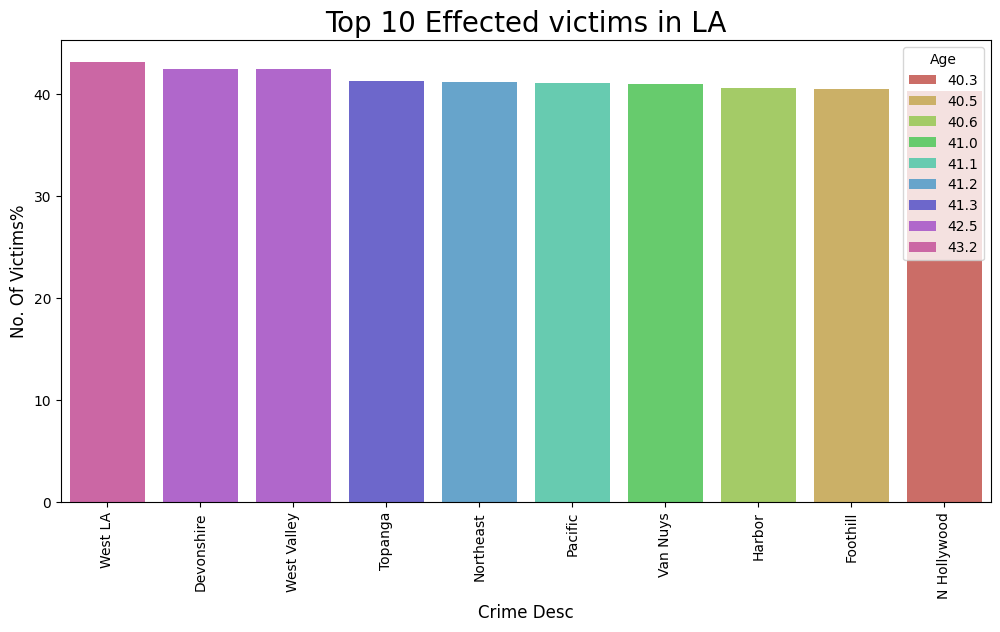

In [16]:
#Average age of Victims in based on Region
from pyspark.sql.functions import col, avg, round
central_region_avg_age = filtered_DF.groupBy(col('AREA NAME')).agg(round(avg(col('Vict Age')),1).alias('Age')).orderBy(col('Age').desc())

plot_graph(central_region_avg_age, 10)

+-----------+-----------+----+
|  AREA NAME|Crime_Count|Rank|
+-----------+-----------+----+
|    Central|      42711|   1|
|77th Street|      38721|   2|
|  Southwest|      38040|   3|
|    Pacific|      33889|   4|
|  Hollywood|      32418|   5|
|  Southeast|      30920|   6|
|    Olympic|      29814|   7|
|N Hollywood|      29110|   8|
|   Wilshire|      29095|   9|
|     Newton|      28149|  10|
|    Topanga|      28025|  11|
|    West LA|      27757|  12|
|    Rampart|      27552|  13|
|   Van Nuys|      27423|  14|
|West Valley|      25139|  15|
|    Mission|      24709|  16|
|  Northeast|      24439|  17|
| Devonshire|      23494|  18|
|     Harbor|      23048|  19|
|   Foothill|      20515|  20|
+-----------+-----------+----+
only showing top 20 rows

Index(['AREA NAME', 'Crime_Count', 'Rank'], dtype='object')


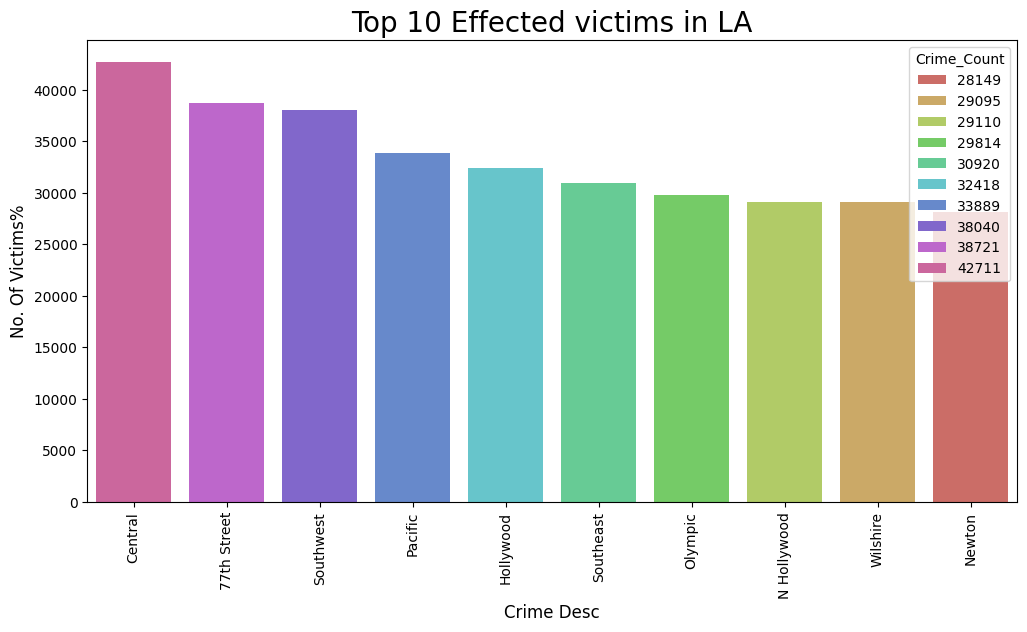

In [17]:
#Area
from pyspark.sql.functions import col, count, rank
from pyspark.sql import Window

# Calculate the count of crimes based on Area Name
crime_counts = filtered_DF.groupBy(col('AREA NAME')).agg(count('Crm Cd').alias('Crime_Count'))


windowSpec = Window.orderBy(col('Crime_Count').desc())


ranked_crime_counts = crime_counts.withColumn('Rank', rank().over(windowSpec))


ranked_crime_counts.show()

plot_graph(ranked_crime_counts, 10)

In [23]:
#Rank the AREA with type of highest occured crimes.

from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank

highest_crime_Area_df = filtered_DF.groupBy(['Crm Cd Desc', 'AREA NAME']).agg(count('AREA NAME').alias('crime count'))
highest_crime_DF = highest_crime_Area_df.withColumn('highest Crime', dense_rank().over(Window.partitionBy(col('crime count')).orderBy(col('Crm Cd Desc')))).where(col('highest Crime') == 1).select(['AREA NAME', 'Crm Cd Desc']).distinct()#.orderBy(col('crime count').desc())
highest_crime_DF.show()
#plot_graph(highest_crime_DF.select(['AREA NAME', 'highest Crime' ]), 22)

AttributeError: ignored

In [19]:
from pyspark.sql.functions import hour, minute, to_timestamp

# Filtering burglaries occurred between 10 PM to 5 AM and victim's age > 60
'''
Late_burglaries = (
    (col('Date Rptd').between('22:00:00', '23:59:59')) | (col('Date Rptd').between('00:00:00', '05:00:00'))
) & (col('Vict Age') > 60) & (col('Crm Cd').isin (['310', '320', '330', '410']))


Early_burglaries =( col('Date Rptd').between('06:00:00', '19:59:59'))  & (col('Vict Age') > 60) & (col('Crm Cd').isin (['310', '320', '330', '410']))

# Applying the filter to identify burglaries based on conditions
filtered_burglaries = filtered_DF.filter(Late_burglaries)
DayTime_burglaries = filtered_DF.filter(Early_burglaries)
#Check_burglaries = filtered_DF.filter(Check_burglaries)

total_count = filtered_burglaries.count()
early_count = DayTime_burglaries.count()
#check_count = Check_burglaries.count()

print("Burgularies in the late night and early morning targetting Senior citizen:", total_count)
print("Burgularies in day time targetting Senior citizen:", early_count)
#print("Burgularies in the late daytime targetting Senior citizen:", check_count)
# Displaying the resulting DataFrame
#filtered_burglaries.show()
'''


night_time_burglary_cnt = filtered_DF.withColumn('hr', hour(to_timestamp(col('TIME OCC')))).filter(((col('hr') >= 22) | (col('hr') < 5)) & (col('Vict Age') > 60) & (col('Crm Cd').isin (['310', '320', '330', '410']))).count()
day_time_burglary_cnt = filtered_DF.withColumn('hr', hour(to_timestamp(col('TIME OCC')))).filter(((col('hr') >= 6) & (col('hr') < 22)) & (col('Vict Age') > 60) & (col('Crm Cd').isin (['310', '320', '330', '410']))).count() #select('hr').distinct().orderBy(col('hr')).show()

print("Burgularies in the late night and early morning targetting Senior citizen based on time occured:", night_time_burglary_cnt)
print("Burgularies in day time targetting Senior citizen based on time occured:", day_time_burglary_cnt)


Burgularies in the late night and early morning targetting Senior citizen: 5186
Burgularies in day time targetting Senior citizen: 5320
Burgularies in the late night and early morning targetting Senior citizen based on time occured: 1984
Burgularies in day time targetting Senior citizen based on time occured: 9357


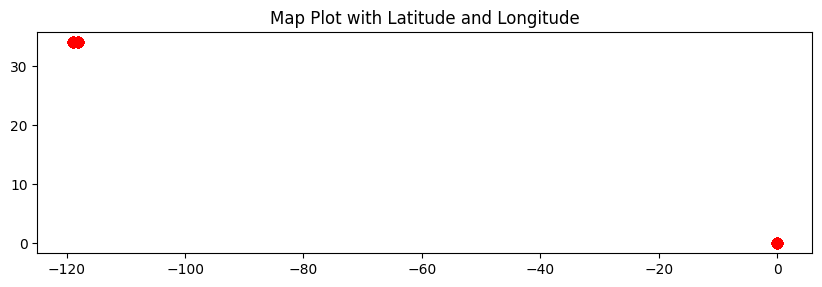

<ipython-input-20-1ebc94916803>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


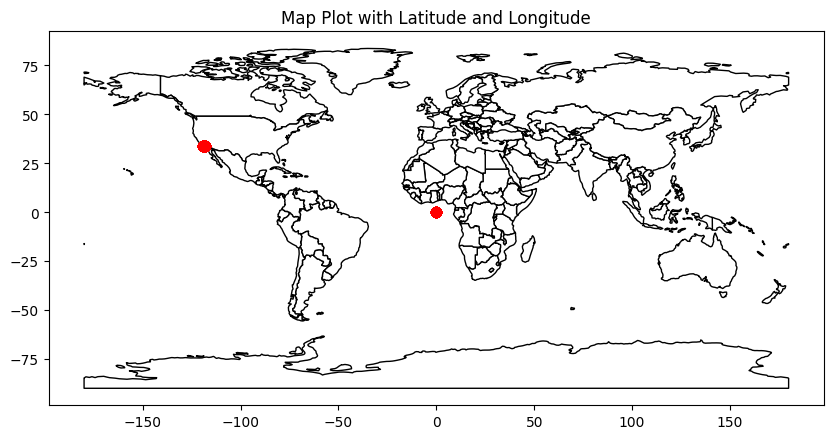

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

pandas_df = filtered_DF.toPandas()
# Create a GeoDataFrame using latitude and longitude columns
gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df.LON, pandas_df.LAT))

# Plotting the map
world = gpd.read_file(file)
ax = world.plot(color='white', edgecolor='black', figsize=(10, 6))

# Plotting the points on the map
gdf.plot(ax=ax, marker='o', color='red', markersize=50)

plt.title('Map Plot with Latitude and Longitude')
plt.show()




gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df.LON, pandas_df.LAT))

# Plotting the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(10, 6))

# Plotting the points on the map
gdf.plot(ax=ax, marker='o', color='red', markersize=50)

plt.title('Map Plot with Latitude and Longitude')
plt.show()

<ipython-input-21-09837740bd83>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

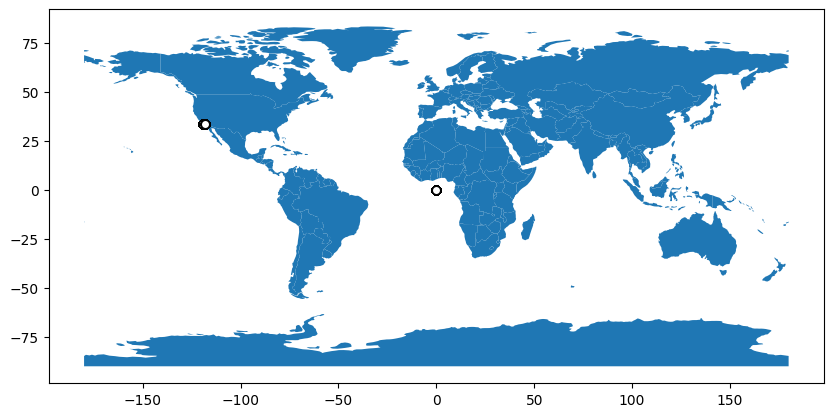

In [21]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
geometry = [Point(xy) for xy in zip(pandas_df['LON'],pandas_df['LAT'])]
gdf = GeoDataFrame(pandas_df,geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)),color='white', edgecolor='black')

In [22]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

#Data Prep for ML

# Create a Spark session
#spark = SparkSession.builder.appName("FeatureExtractionExample").getOrCreate()
#drive.mount('/content/drive')
# Load data into a Spark DataFrame
#file1 = '/content/drive/MyDrive/Data Engineering - Crime Analysis/DataSource/Crime_Data_from_2020_to_Present.csv'
#data = spark.createDataFrame(pd.read_csv(file1))

# Display the schema of the DataFrame
#data.printSchema()




categorical_cols = ["AREA NAME", "Crm Cd Desc"]


numerical_cols = ["Vict Age", "Rpt Dist No"]


indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]


encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_onehot") for col in categorical_cols]


assembler = VectorAssembler(inputCols=numerical_cols + [col+"_onehot" for col in categorical_cols], outputCol="features")


pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and transform the data using the pipeline
transformed_data = pipeline.fit(filtered_DF).transform(filtered_DF)


transformed_data.show(truncate=False)


#spark.stop()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+---------+----------+----------+--------+----+-----------+-----------+--------+------+--------------------------------------------------------+-------------------------------------------------+--------+--------+------------+---------+--------------------------------------------------+--------------+----------------------------------------------+------+------------+--------+--------+--------+--------+----------------------------------------+------------+---+----+---------------+-----------------+----------------+------------------+---------------------------------------+
|DR_NO    |Date Rptd |DATE OCC  |TIME OCC|AREA|AREA NAME  |Rpt Dist No|Part 1-2|Crm Cd|Crm Cd Desc                                             |Mocodes                                          |Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc                                       |Weapon 